In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/open-problems-multimodal/sample_submission.csv
/kaggle/input/open-problems-multimodal/train_cite_targets.h5
/kaggle/input/open-problems-multimodal/metadata_cite_day_2_donor_27678.csv
/kaggle/input/open-problems-multimodal/test_multi_inputs.h5
/kaggle/input/open-problems-multimodal/evaluation_ids.csv
/kaggle/input/open-problems-multimodal/train_cite_inputs.h5
/kaggle/input/open-problems-multimodal/train_multi_targets.h5
/kaggle/input/open-problems-multimodal/train_multi_inputs.h5
/kaggle/input/open-problems-multimodal/metadata.csv
/kaggle/input/open-problems-multimodal/test_cite_inputs_day_2_donor_27678.h5
/kaggle/input/open-problems-multimodal/test_cite_inputs.h5
/kaggle/input/cse529/cite_train_X.npy
/kaggle/input/cse529/cite_train_y.h5


In [2]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

import scipy
import scipy.sparse

In [3]:
train_inputs = df = pd.DataFrame(np.load('/kaggle/input/cse529/cite_train_X.npy'))

In [4]:
train_inputs

,0,1,2,3,4,5,6,7,8,9,...,543,544,545,546,547,548,549,550,551,552
0,237.895706,31.896015,-23.286053,-18.044579,-10.533789,-3.342738,1.660645,-8.374366,5.821663,-7.484444,...,0.000000,0.000000,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,233.411697,40.246300,-19.453917,-18.165651,-13.273949,-5.741552,3.628348,5.092322,-5.424098,-8.376875,...,0.000000,4.039545,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,249.848831,-4.472554,-9.041818,29.289938,2.575403,-30.254951,8.537174,17.840561,0.074249,-8.830885,...,0.000000,3.847321,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,289.418274,-21.751209,8.090761,-23.092079,-21.926624,-10.032563,6.657254,-2.745777,-11.738263,10.215189,...,0.000000,4.513782,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,293.918121,-40.289055,-16.685734,16.128412,-3.859625,-1.376259,9.992336,-19.261257,4.618667,1.792382,...,0.000000,3.518610,3.51861,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70983,213.802338,36.713196,-21.122686,4.935718,-9.799493,-4.237913,-13.888659,4.794420,6.532759,0.496521,...,0.000000,5.774556,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
70984,260.978363,-16.405834,-29.930393,19.197748,-8.482071,-16.480158,-0.945776,6.920582,9.938651,14.573128,...,0.000000,0.000000,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
70985,267.154724,-14.275597,-7.984200,37.240253,7.220788,-21.929052,4.682098,14.404635,-4.308122,-1.931374,...,0.000000,3.815622,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
70986,273.470612,-23.911606,31.285852,3.626095,-32.574280,2.356098,2.017989,-12.521918,6.971073,3.010725,...,0.000000,4.985945,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
train_target = pd.read_hdf('/kaggle/input/cse529/cite_train_y.h5')

In [35]:
from sklearn.multioutput import MultiOutputRegressor
X = train_inputs[:50000]
y = train_target[:50000]
model = MultiOutputRegressor(LinearRegression())
model.fit(X, y)

MultiOutputRegressor(estimator=LinearRegression())

In [36]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

In [37]:
X_test = train_inputs[50000:]
y_test = train_target[50000:]
y_va_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_va_pred)
cor = correlation_score(y_test, y_va_pred)
print(f'mse: {mse}, cor: {cor}')

mse: 2.436244487762451, cor: 0.8799600338237615


In [6]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [27]:
import json
f = open ('/kaggle/input/cse-529-features/features_names.json', "r")
features = json.loads(f.read())
feature_names = json.loads(features)

In [32]:
gene_name = ['ENSG00000134256_CD101', 'ENSG00000170458_CD14', 'ENSG00000177575_CD163', 'ENSG00000177455_CD19', 'ENSG00000116824_CD2', 'ENSG00000012124_CD22', 'ENSG00000150637_CD226', 'ENSG00000272398_CD24', 'ENSG00000122223_CD244', 'ENSG00000139193_CD27', 'ENSG00000120217_CD274', 'ENSG00000105383_CD33', 'ENSG00000135218_CD36', 'ENSG00000004468_CD38', 'ENSG00000010610_CD4', 'ENSG00000101017_CD40', 'ENSG00000026508_CD44', 'ENSG00000196776_CD47', 'ENSG00000117091_CD48', 'ENSG00000169442_CD52', 'ENSG00000116815_CD58', 'ENSG00000135404_CD63', 'ENSG00000110848_CD69', 'ENSG00000173762_CD7', 'ENSG00000137101_CD72', 'ENSG00000110651_CD81', 'ENSG00000085117_CD82', 'ENSG00000112149_CD83', 'ENSG00000114013_CD86', 'ENSG00000010278_CD9', 'ENSG00000125810_CD93', 'ENSG00000168329_CX3CR1', 'ENSG00000204592_HLA-E', 'ENSG00000139187_KLRG1']
f = open ('/kaggle/input/target-proteins/protein_list.json', "r")
target_proteins = json.loads(f.read())
target_proteins = json.loads(target_proteins)
correnspond_gene_pro = {}
for i, gene in enumerate(gene_name):
    for j, pro in enumerate(target_proteins):
        if gene.split('_')[1] == pro:
            print(f'gene_{gene}: {i} ---- {pro}: {j}')
            correnspond_gene_pro[j] = f"gene_{gene}: {i} ---- {pro}: {j}"

gene_ENSG00000134256_CD101: 0 ---- CD101: 137
gene_ENSG00000170458_CD14: 1 ---- CD14: 25
gene_ENSG00000177575_CD163: 2 ---- CD163: 91
gene_ENSG00000177455_CD19: 3 ---- CD19: 13
gene_ENSG00000116824_CD2: 4 ---- CD2: 95
gene_ENSG00000012124_CD22: 5 ---- CD22: 107
gene_ENSG00000150637_CD226: 6 ---- CD226: 96
gene_ENSG00000272398_CD24: 7 ---- CD24: 71
gene_ENSG00000122223_CD244: 8 ---- CD244: 75
gene_ENSG00000139193_CD27: 9 ---- CD27: 53
gene_ENSG00000120217_CD274: 10 ---- CD274: 1
gene_ENSG00000105383_CD33: 11 ---- CD33: 14
gene_ENSG00000135218_CD36: 12 ---- CD36: 113
gene_ENSG00000004468_CD38: 13 ---- CD38: 104
gene_ENSG00000010610_CD4: 14 ---- CD4: 23
gene_ENSG00000101017_CD40: 15 ---- CD40: 7
gene_ENSG00000026508_CD44: 16 ---- CD44: 24
gene_ENSG00000196776_CD47: 17 ---- CD47: 5
gene_ENSG00000117091_CD48: 18 ---- CD48: 6
gene_ENSG00000169442_CD52: 19 ---- CD52: 9
gene_ENSG00000116815_CD58: 20 ---- CD58: 68
gene_ENSG00000135404_CD63: 21 ---- CD63: 111
gene_ENSG00000110848_CD69: 22 ---- C

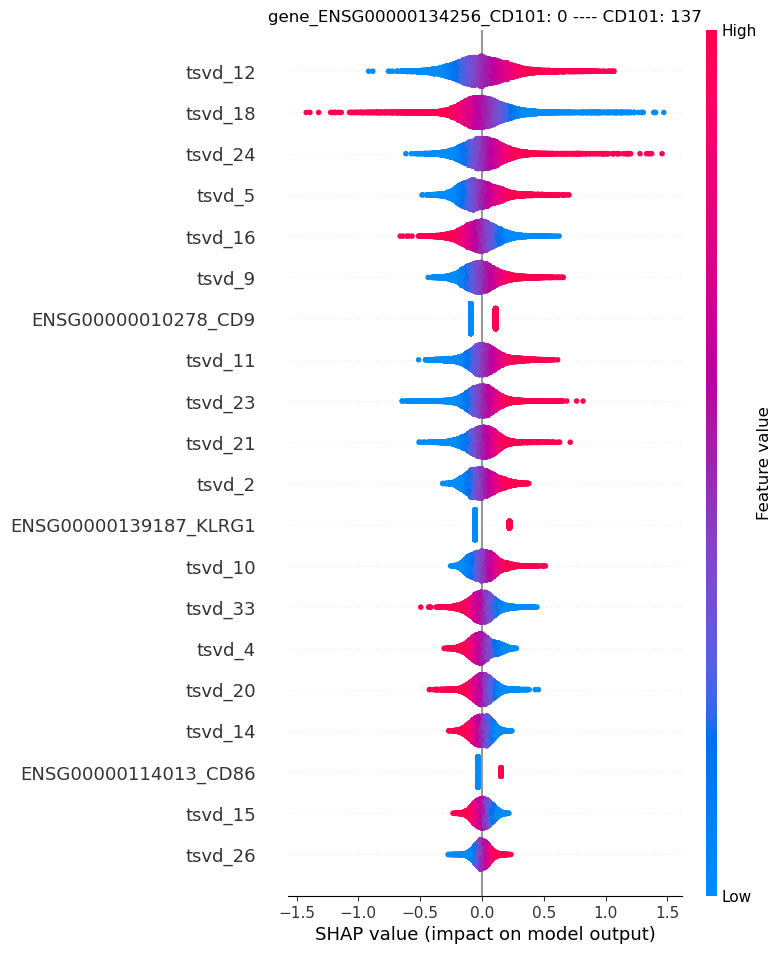

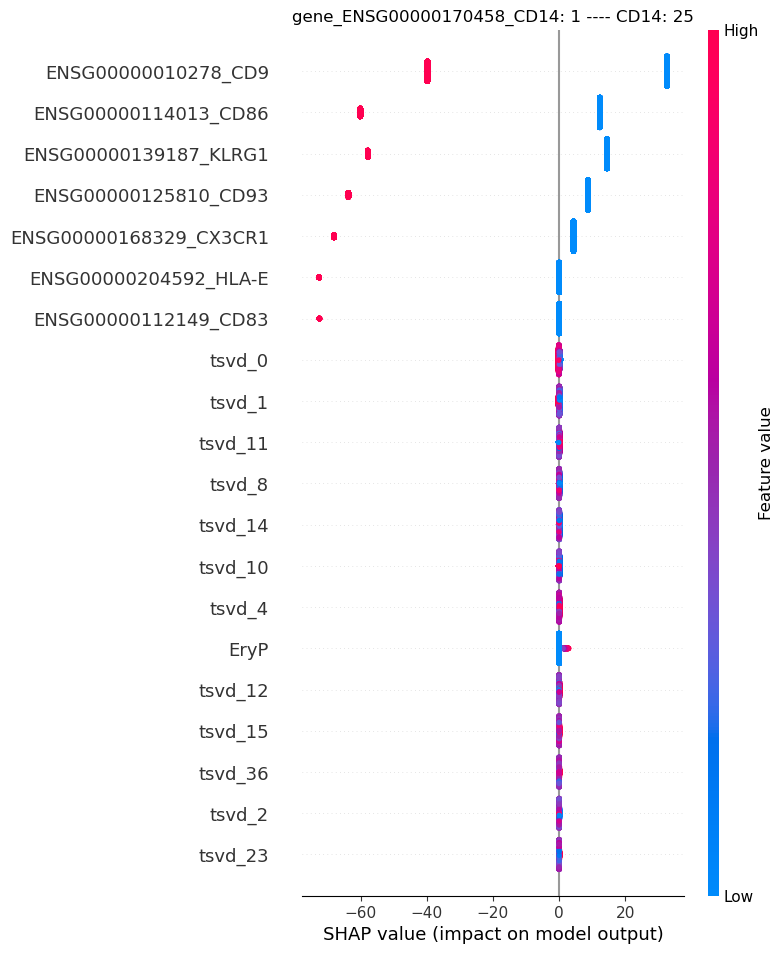

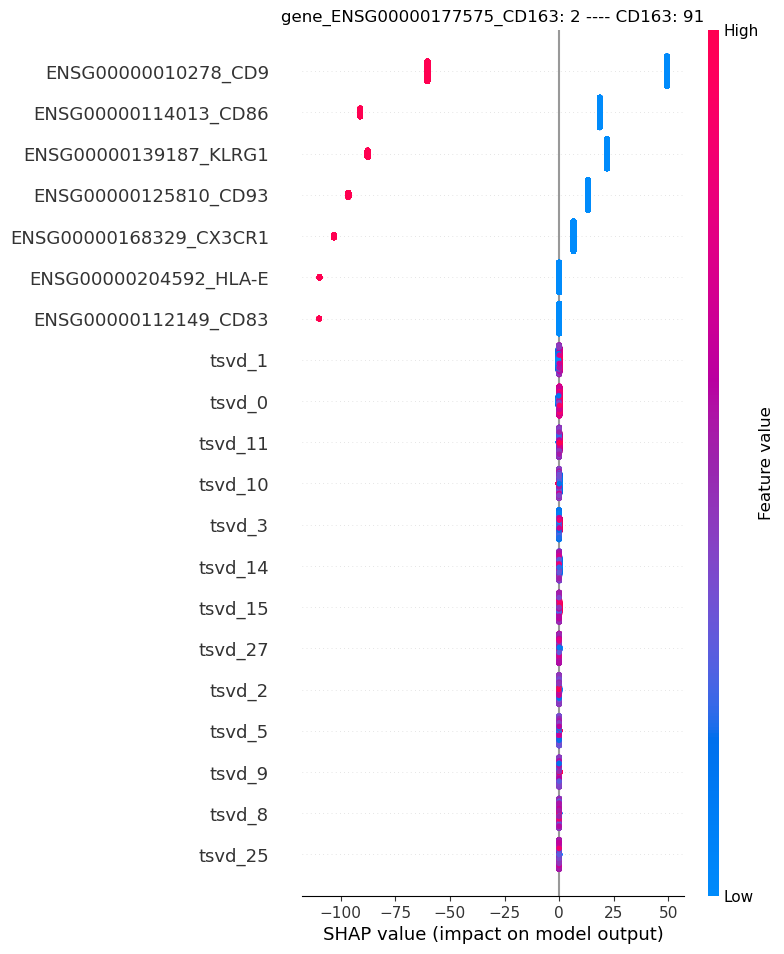

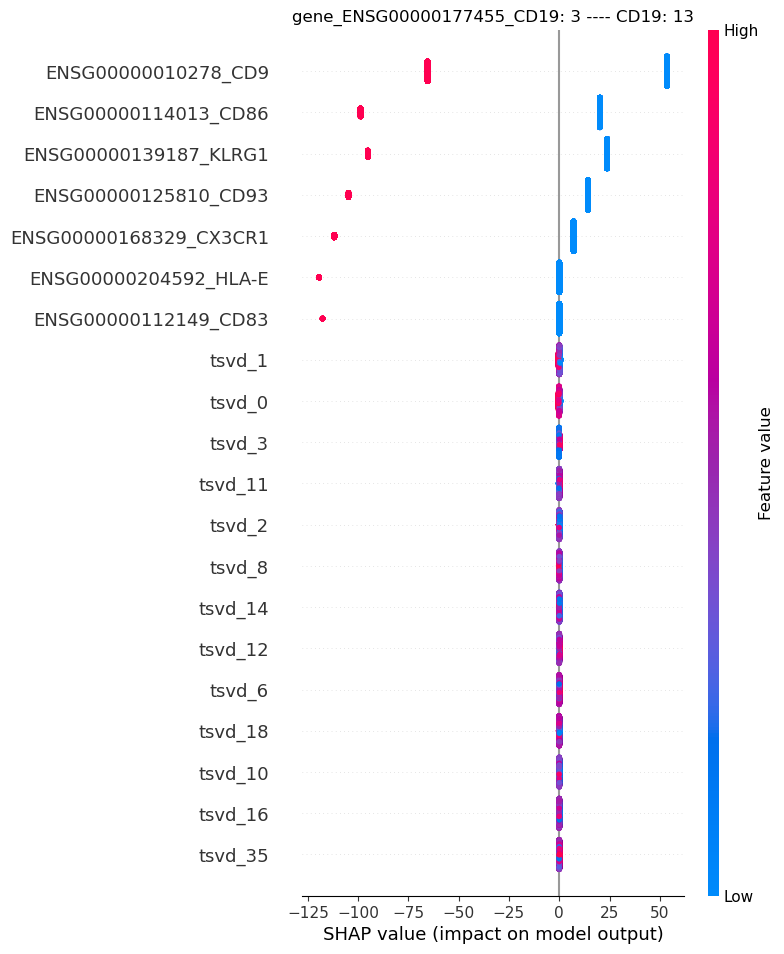

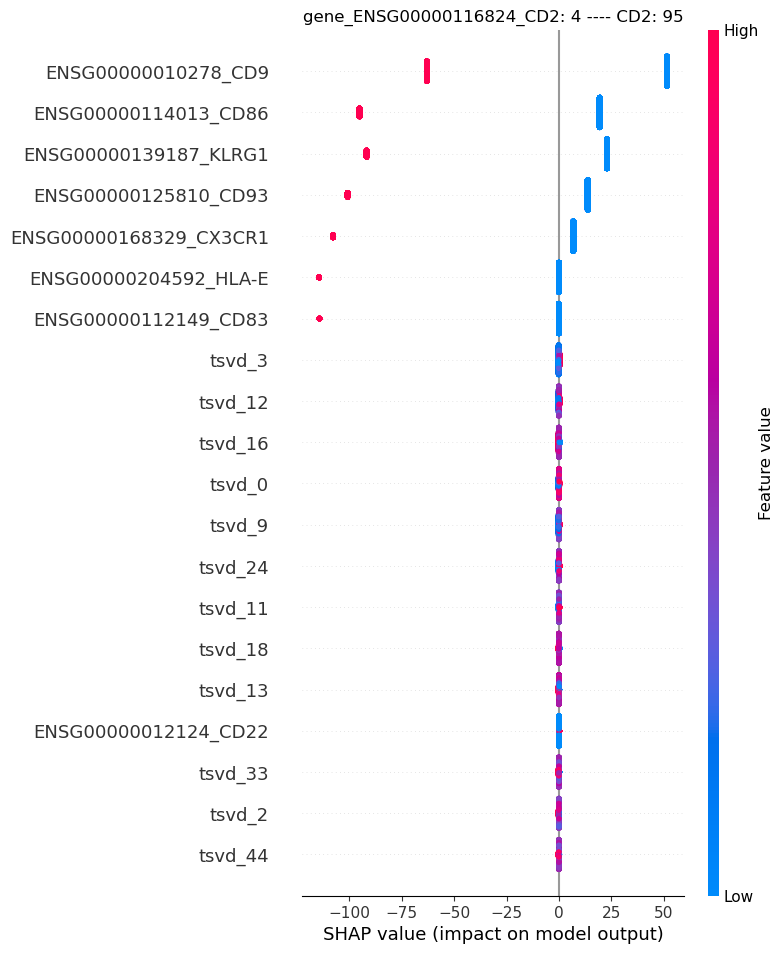

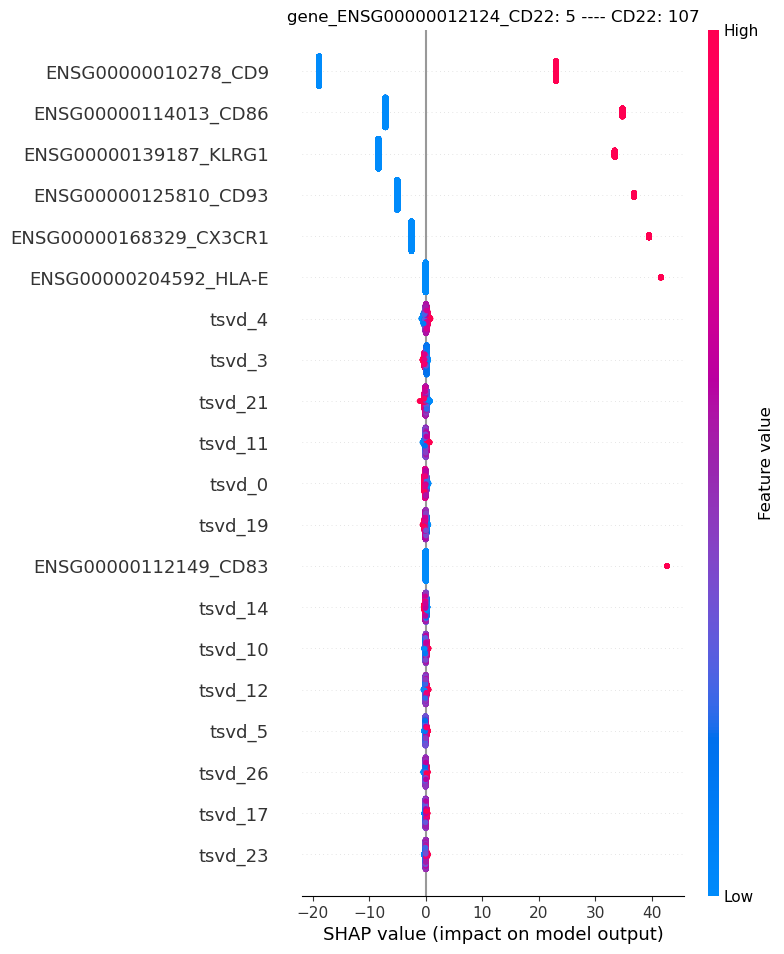

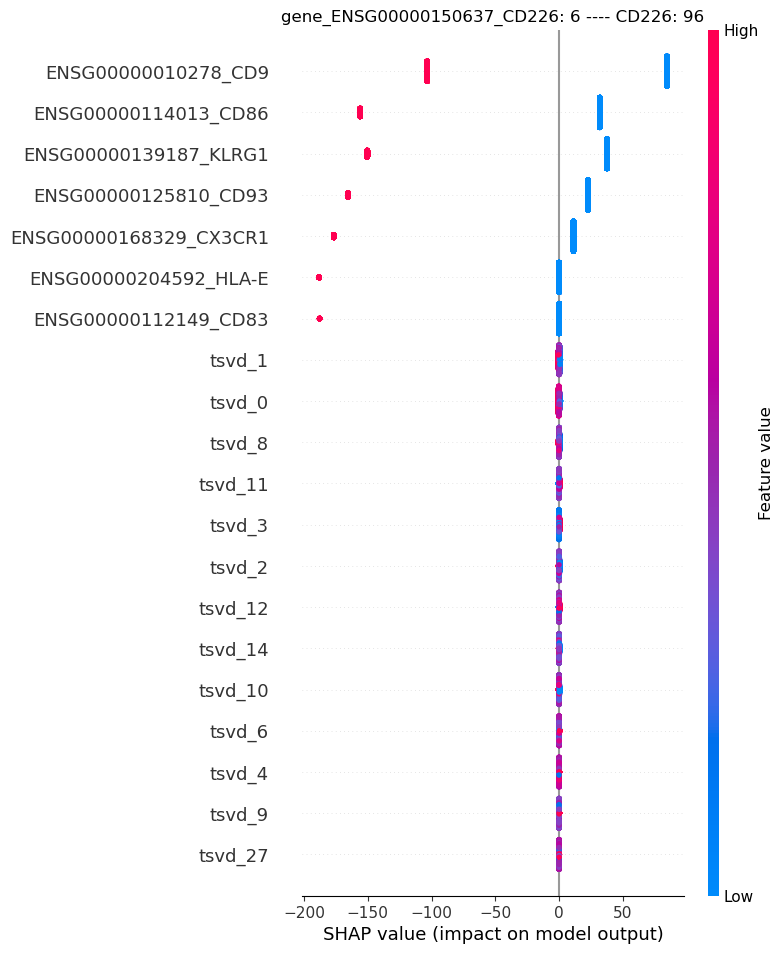

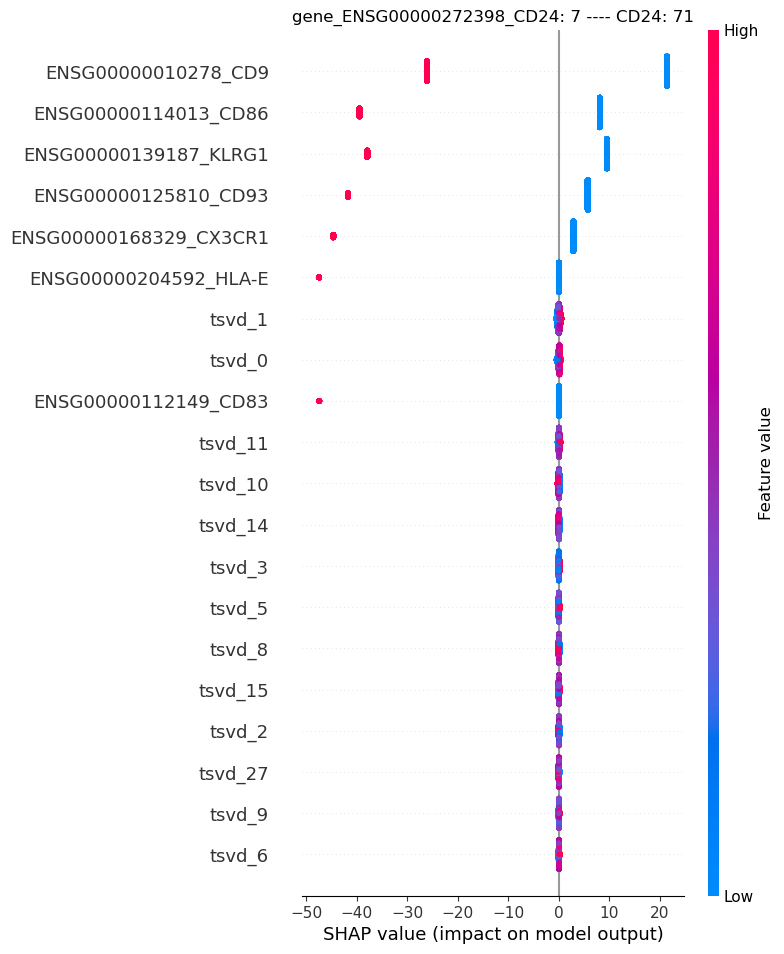

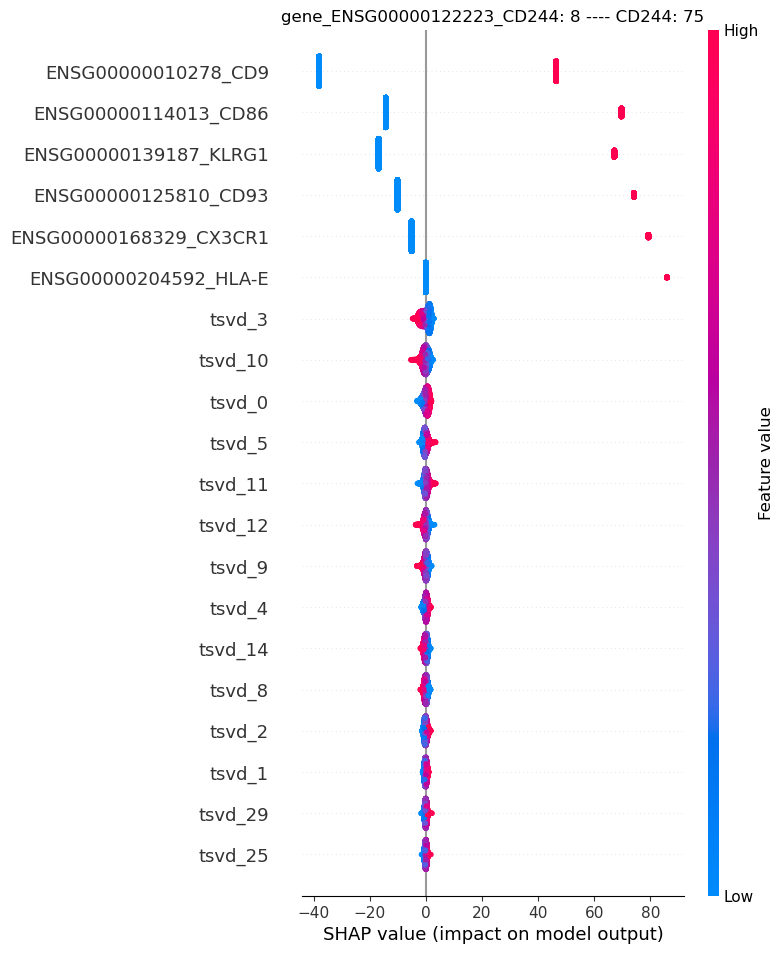

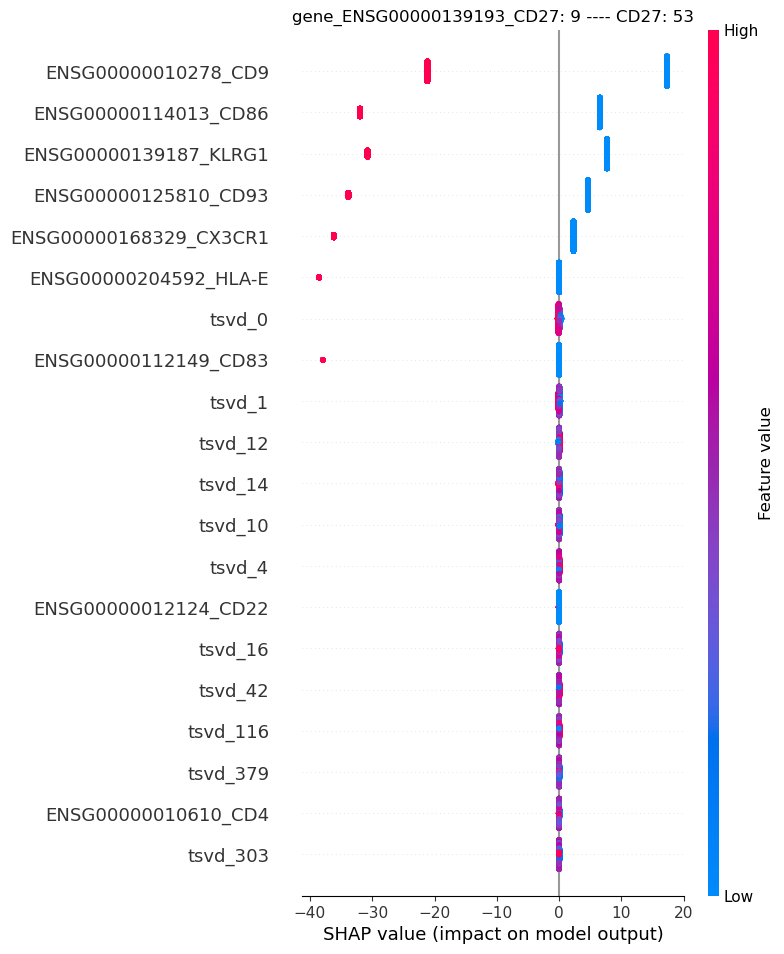

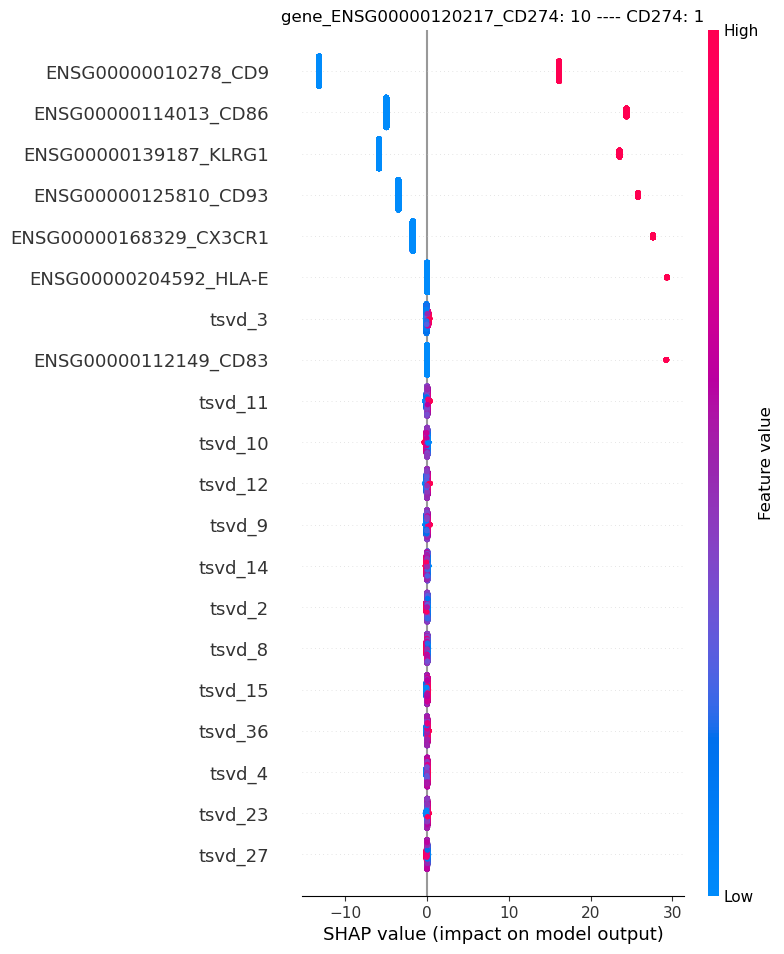

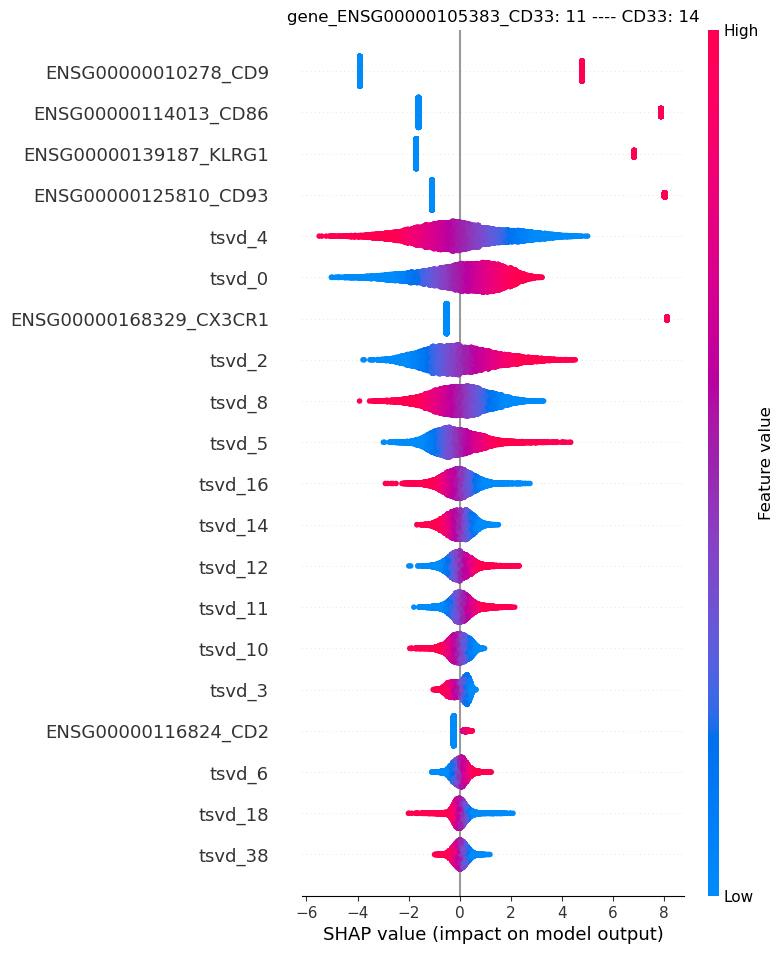

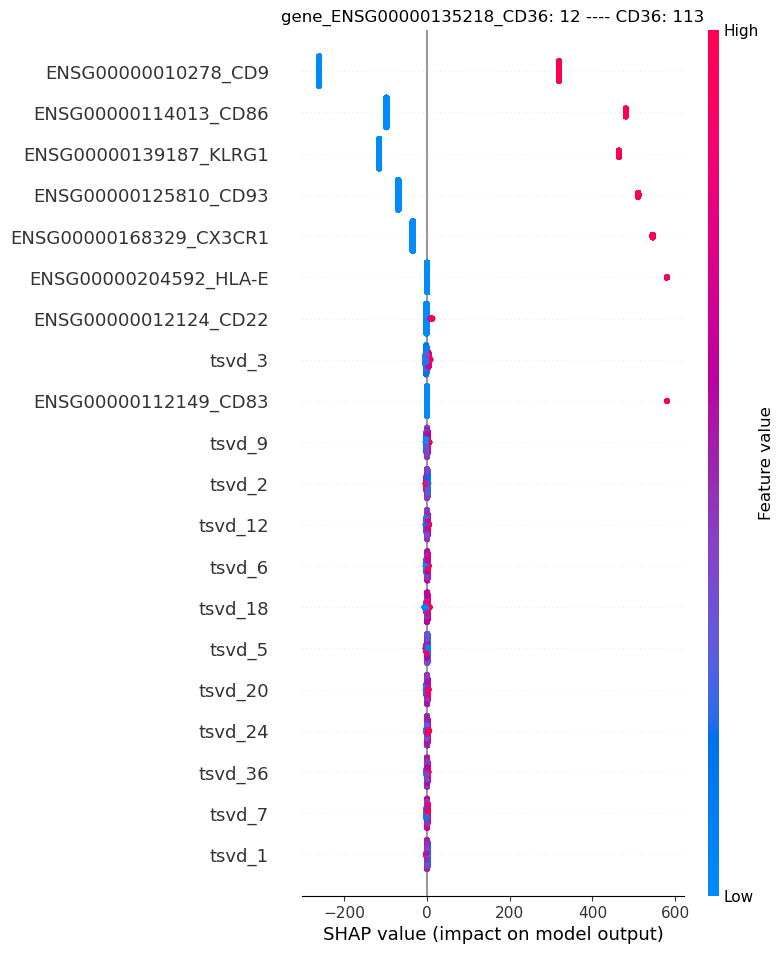

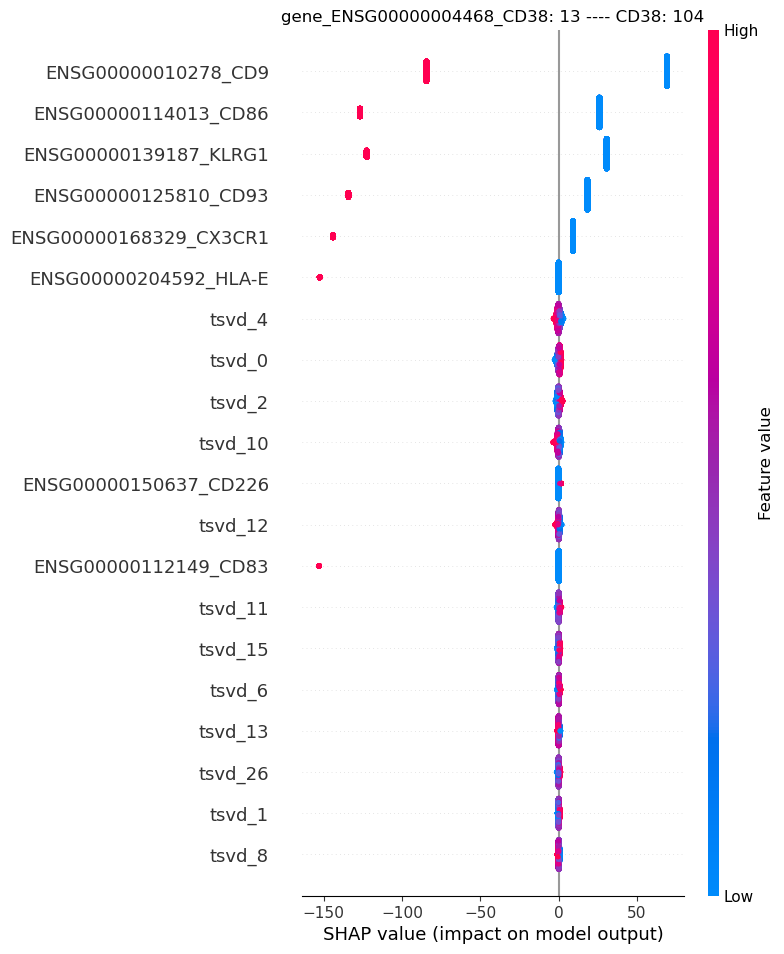

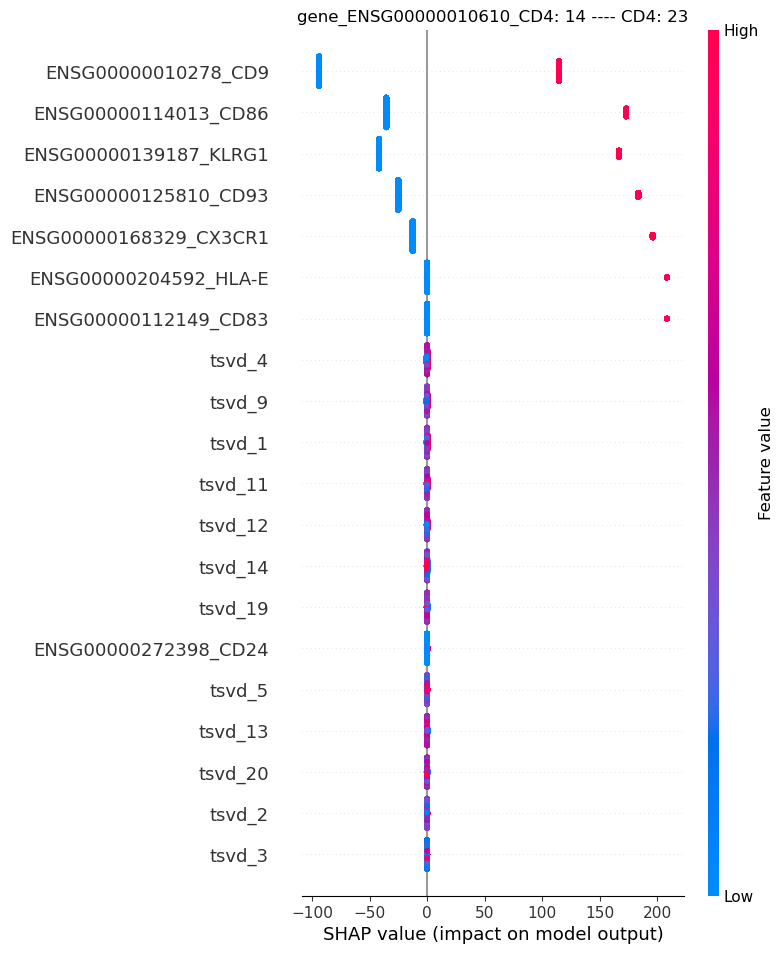

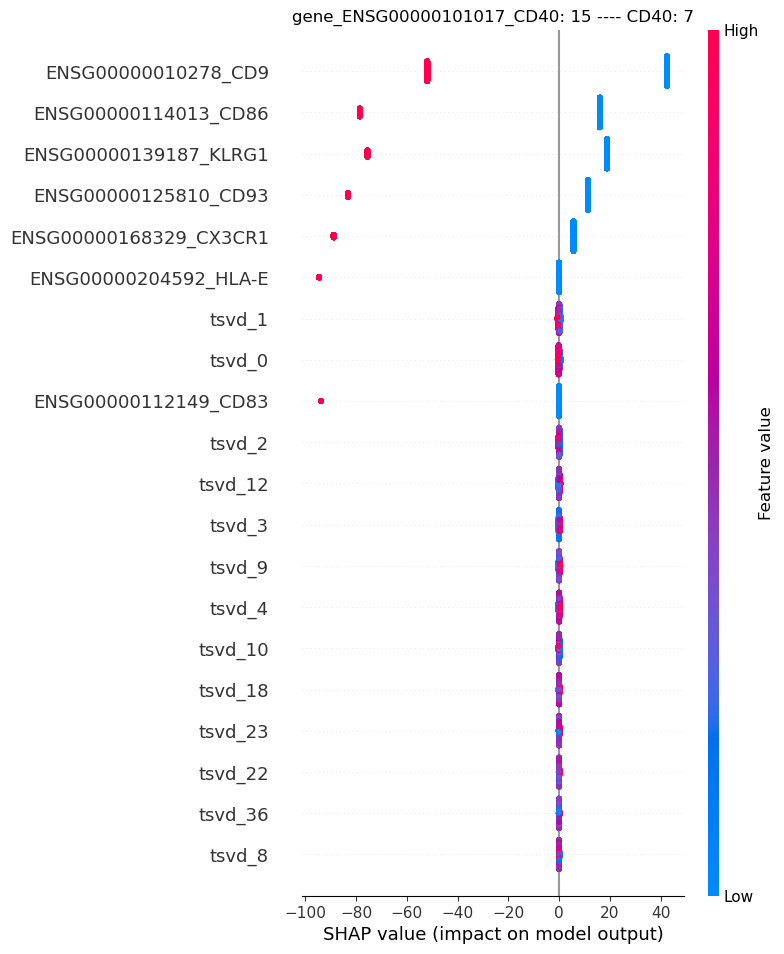

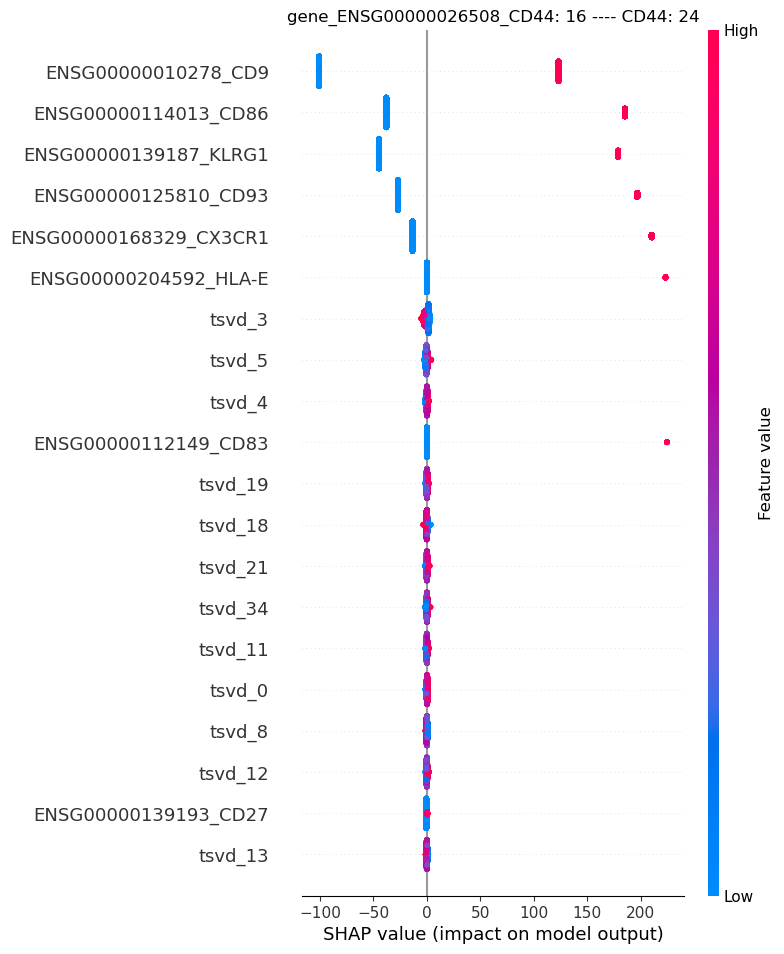

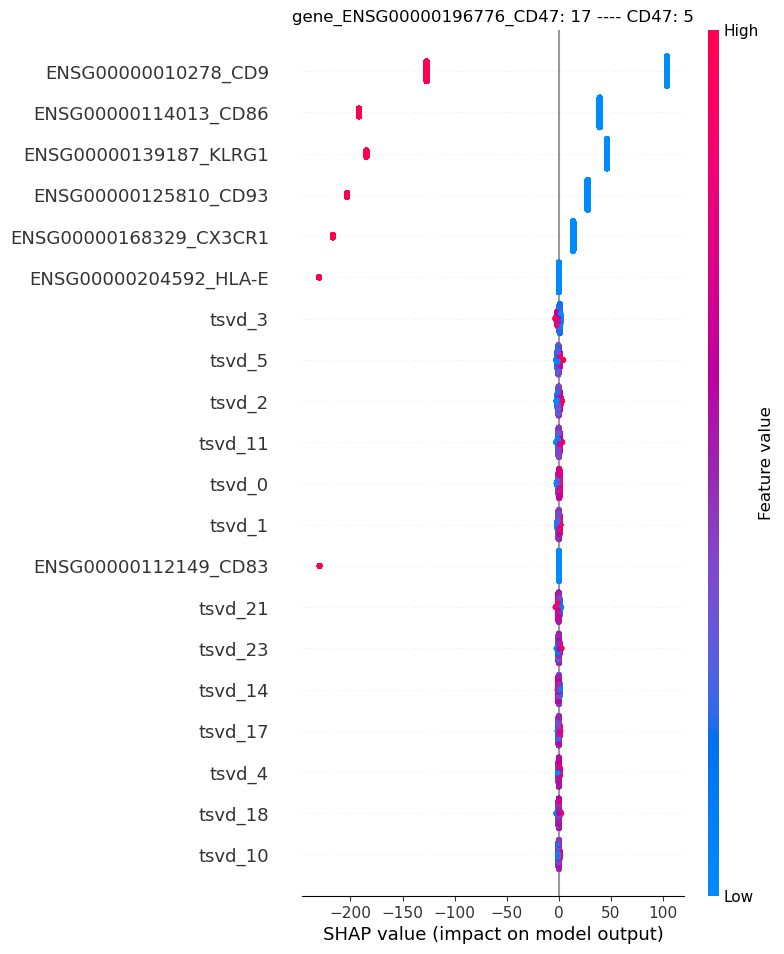

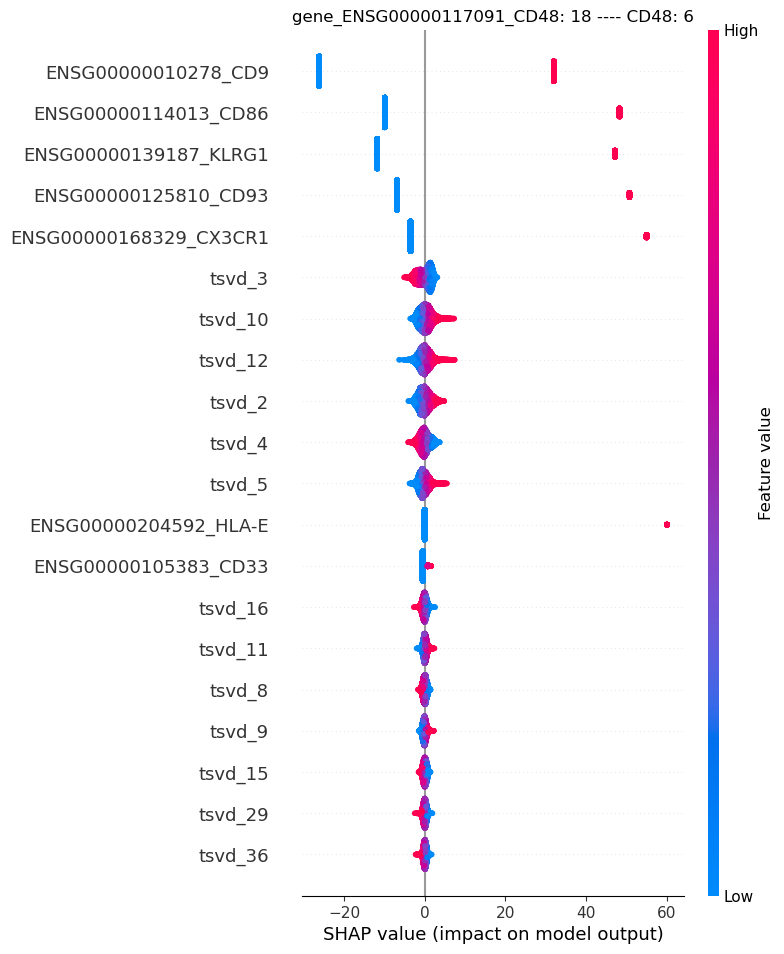

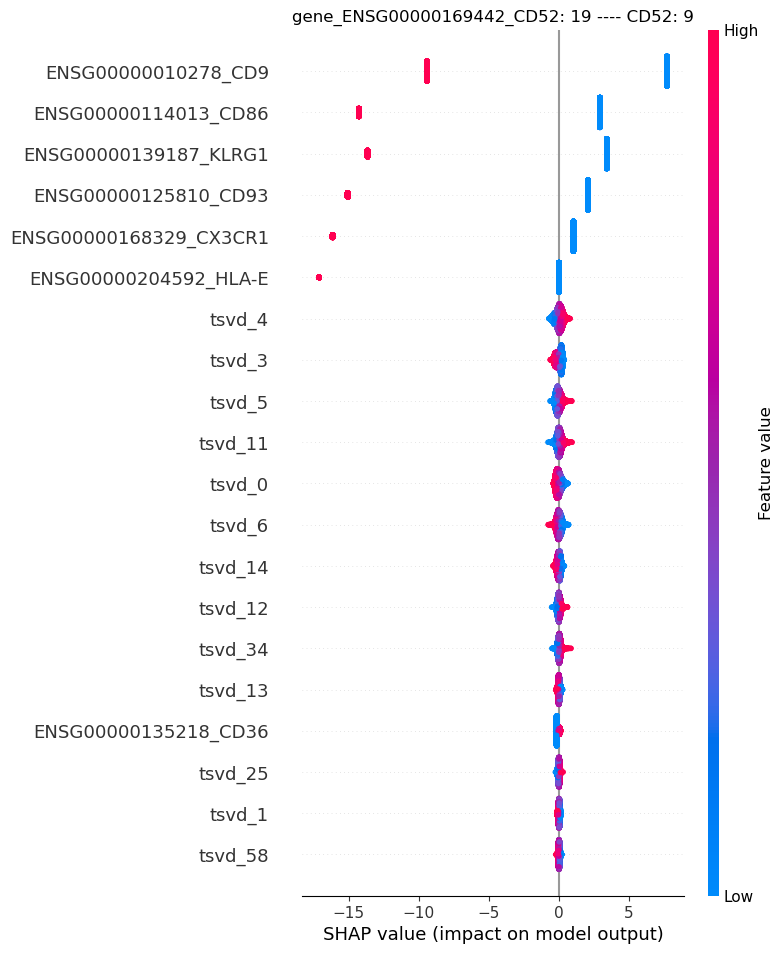

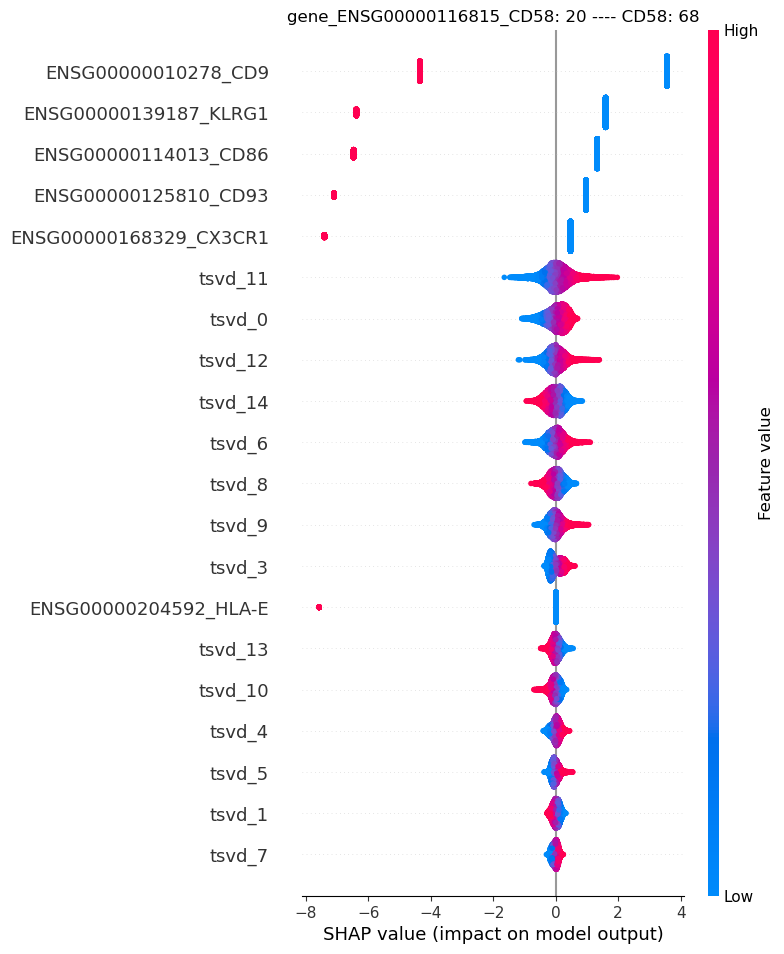

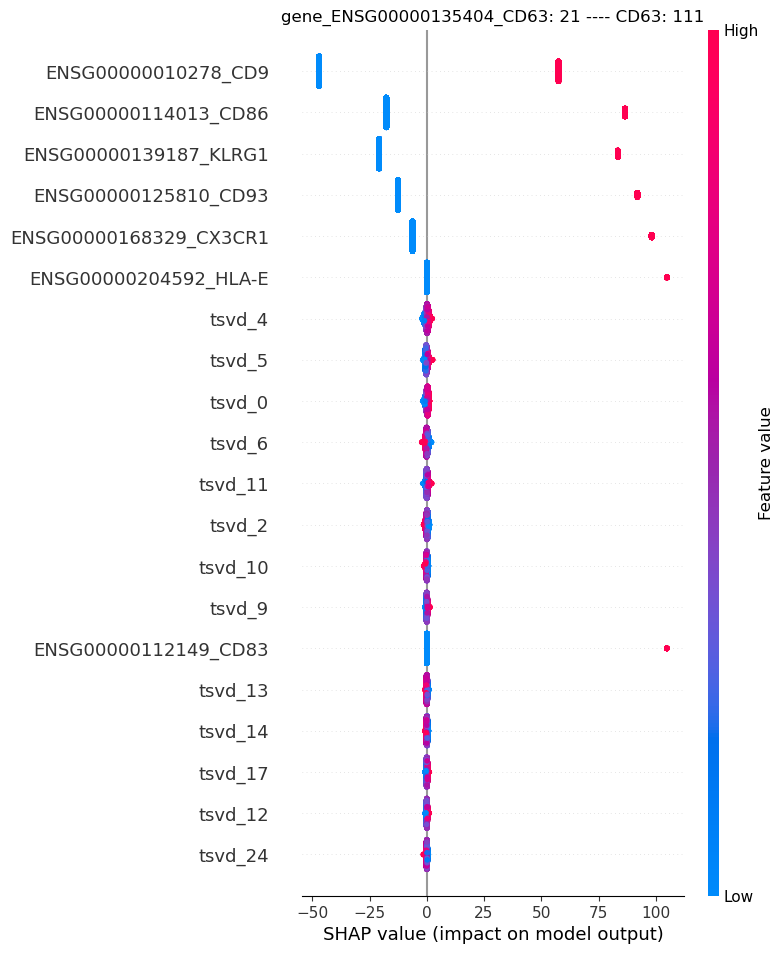

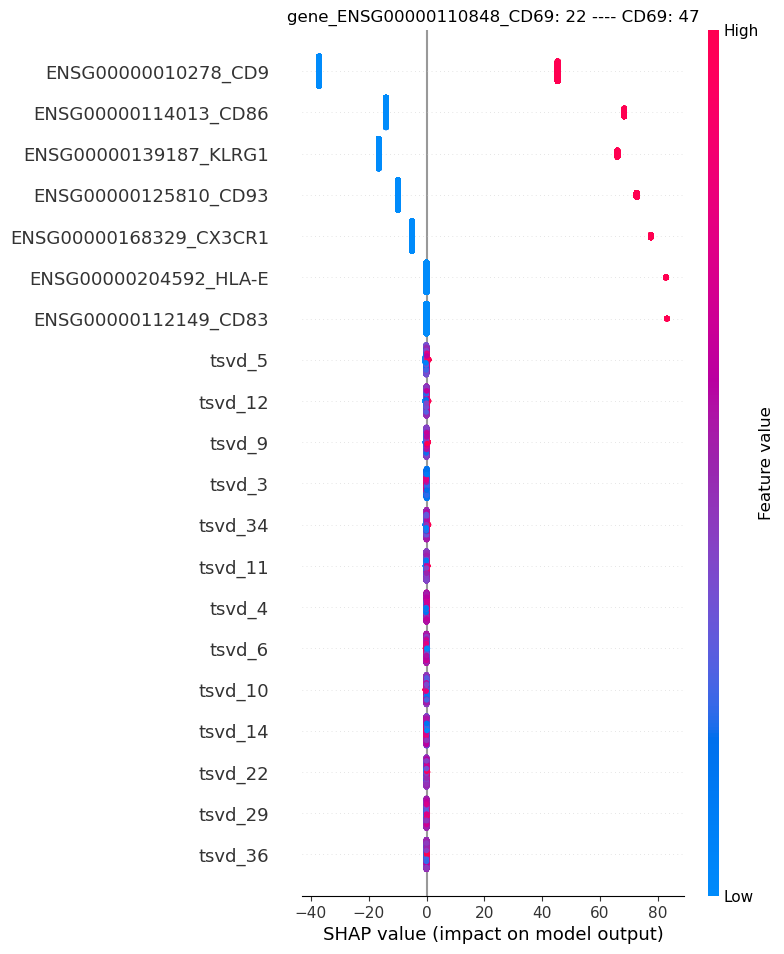

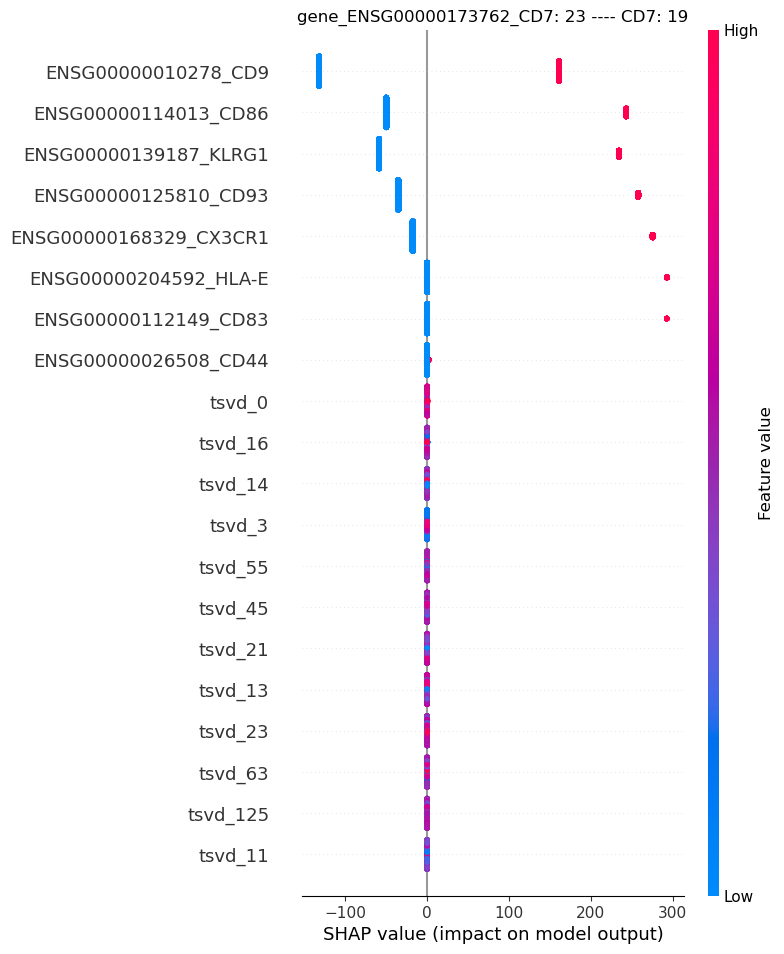

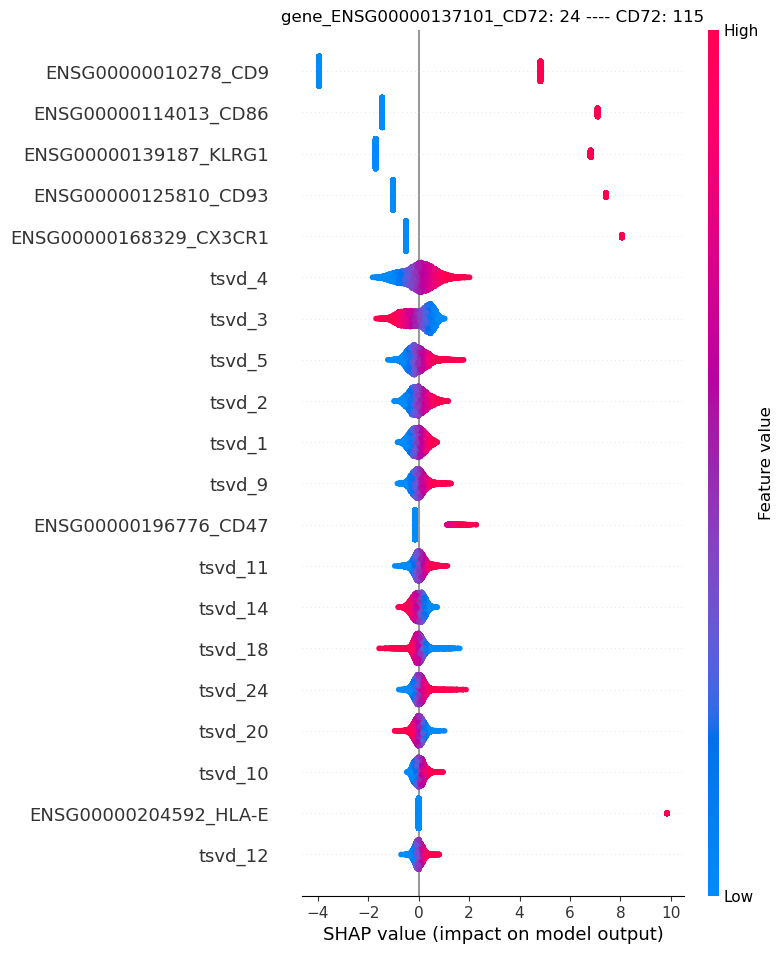

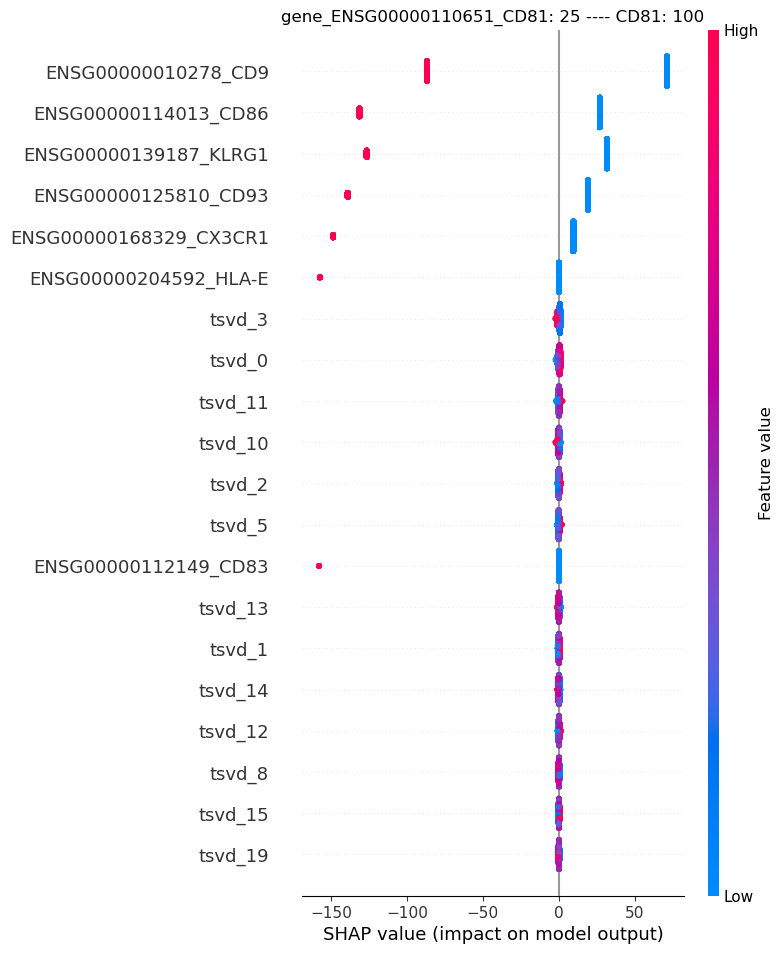

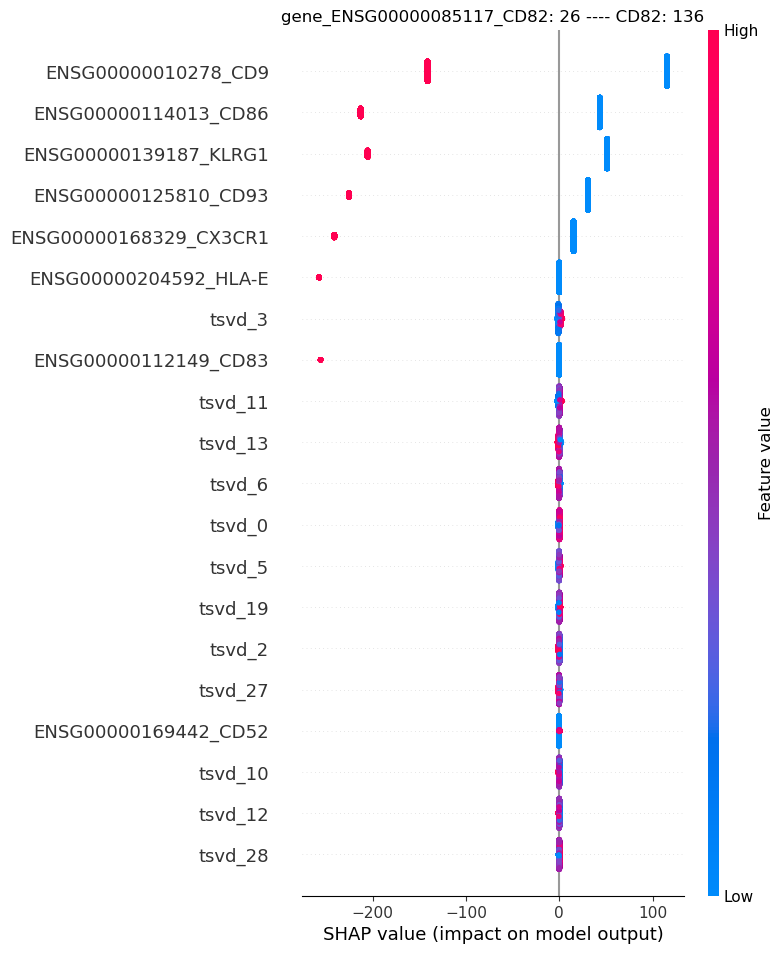

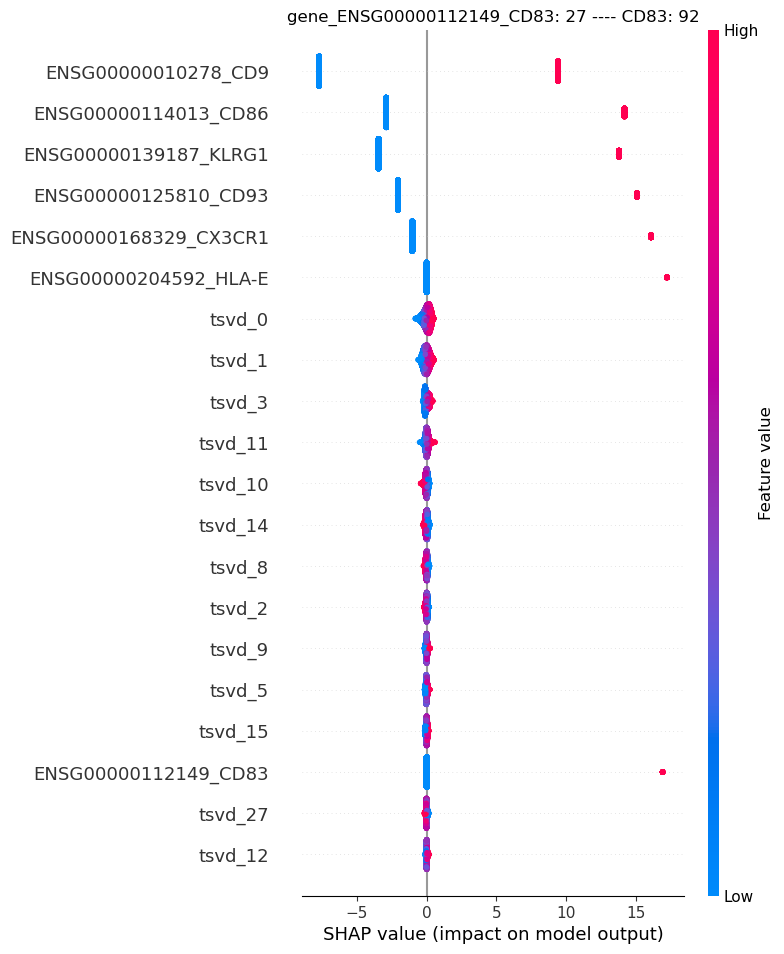

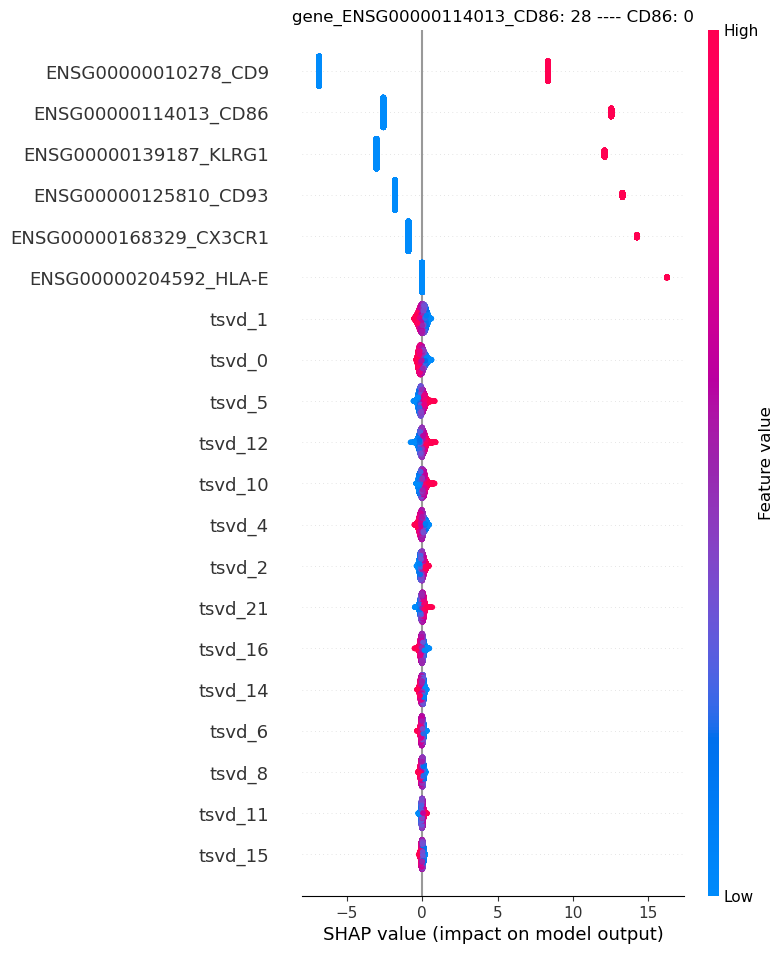

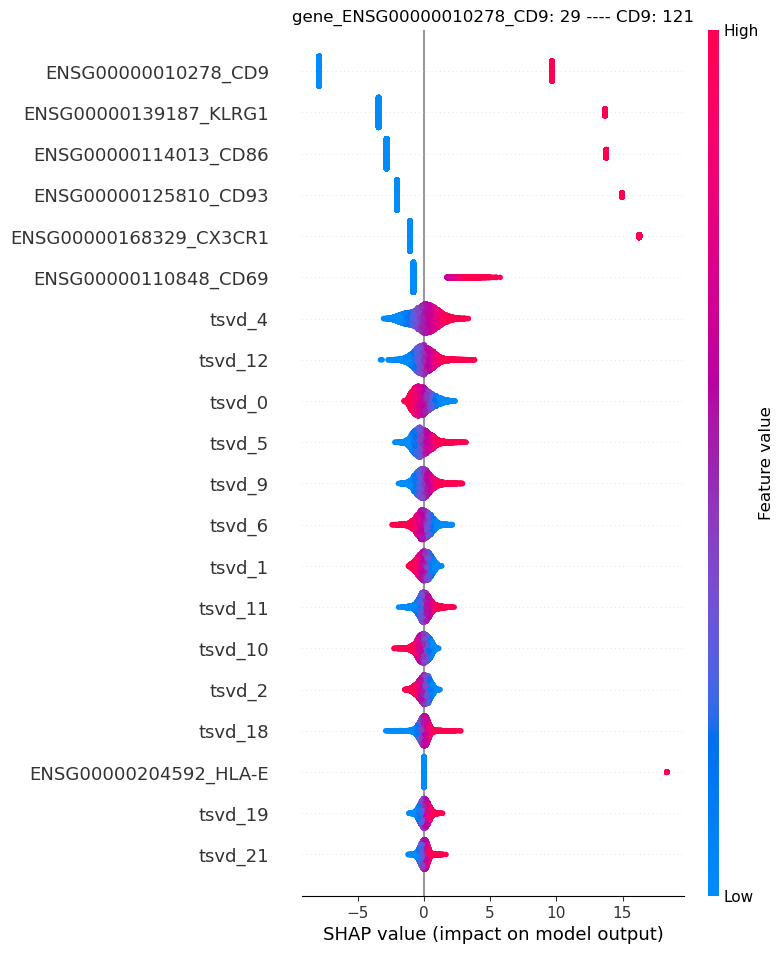

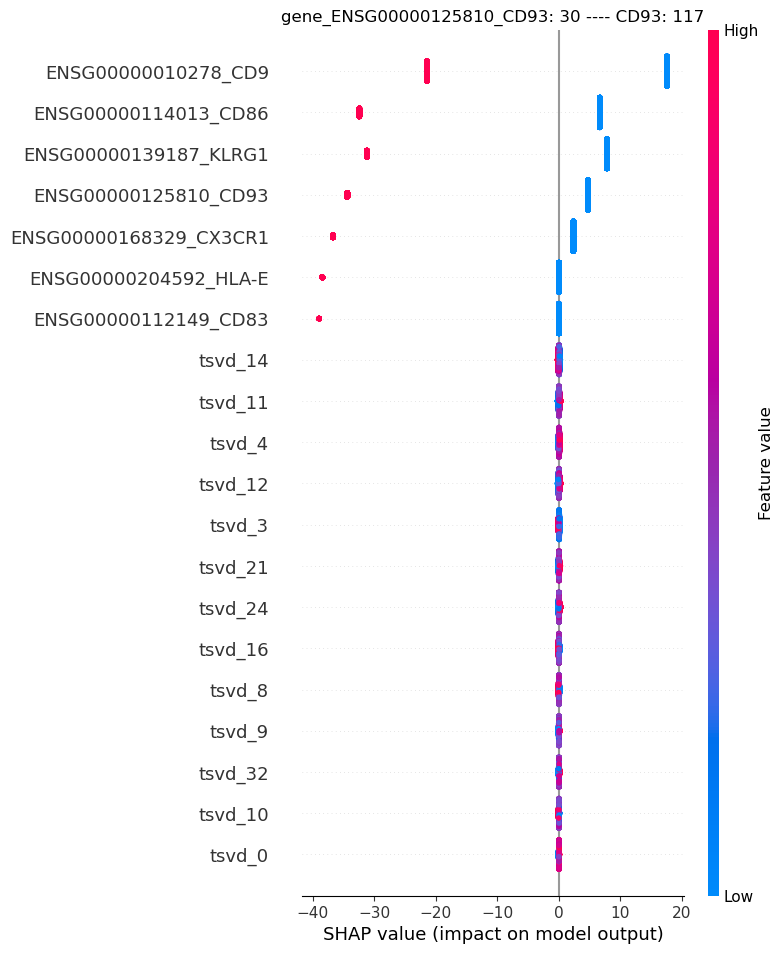

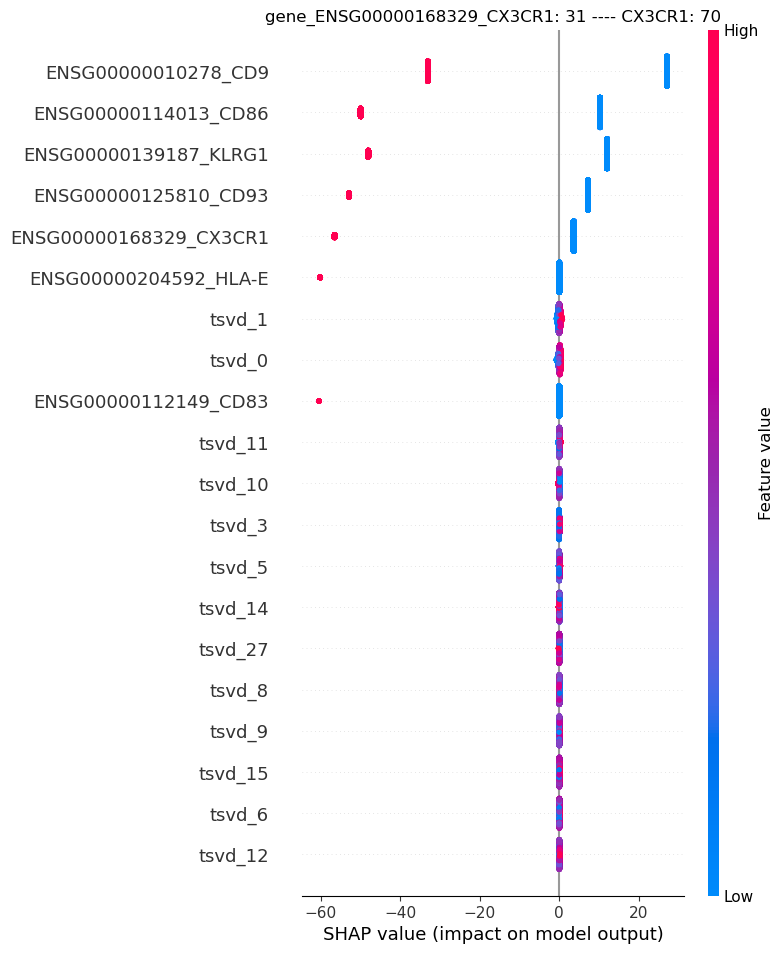

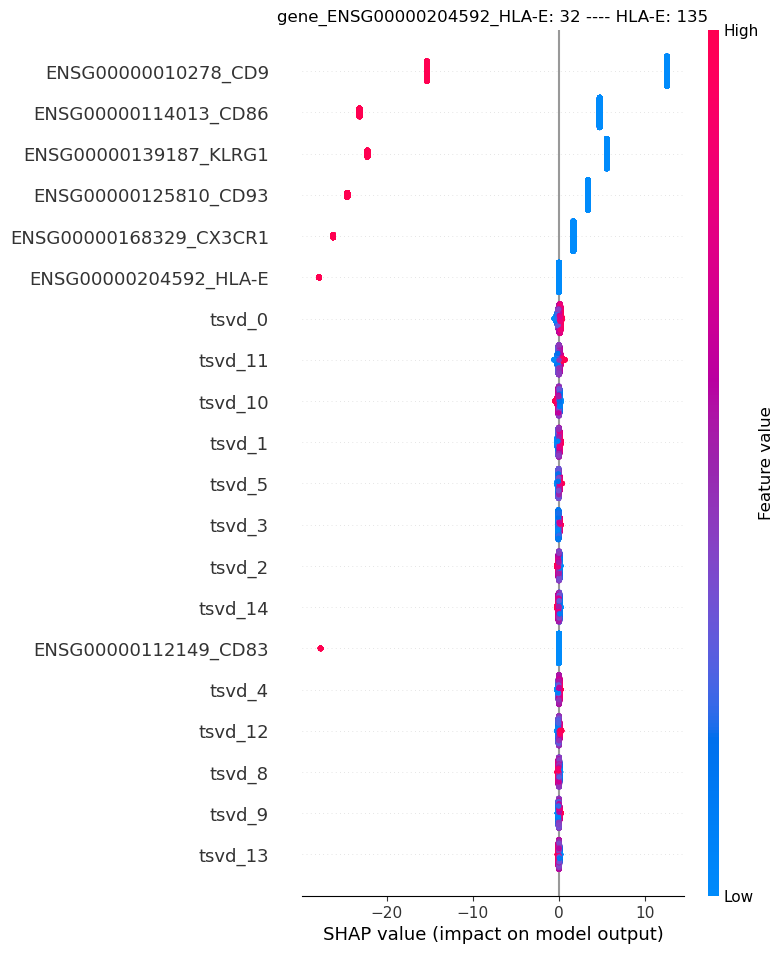

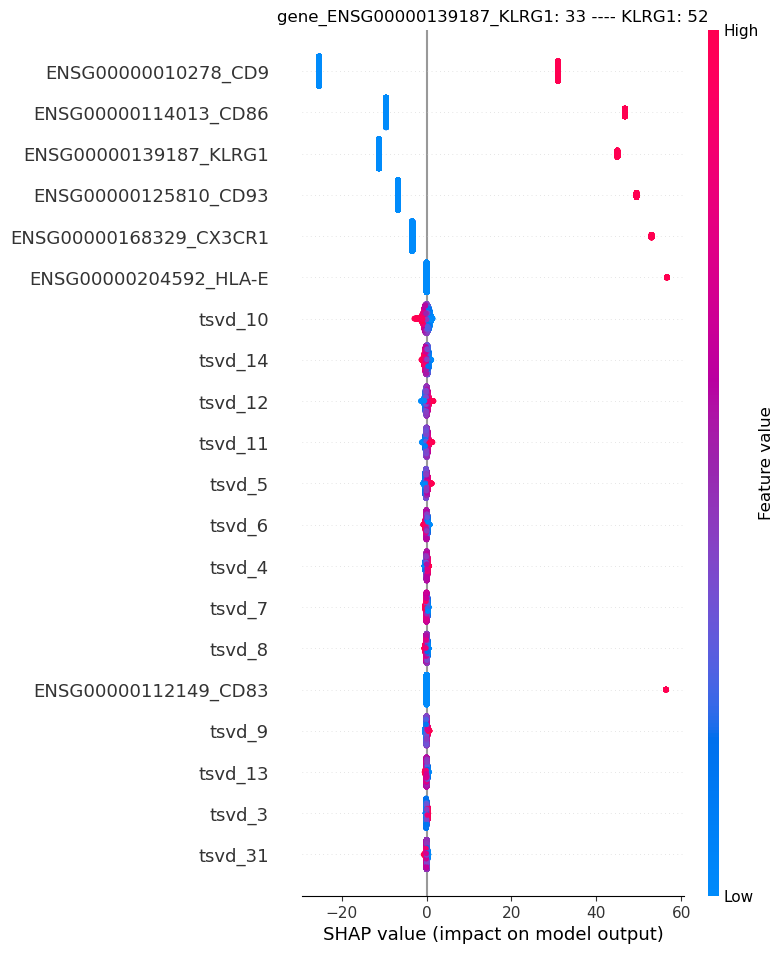

In [34]:
import warnings
warnings.filterwarnings('ignore')
import shap
X = train_inputs[:50000]
X_test = train_inputs[50000:]
for key, val in correnspond_gene_pro.items():
    y_i = train_target[:50000].iloc[:,key]
    model = LinearRegression()
    model.fit(X, y_i)
    y_i_pred = model.predict(X_test)
    explainer = shap.explainers.Linear(model,X_test)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title(val)     
    plt.savefig(f'/kaggle/working/{val}.png')
    plt.show()
    